In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PCA and EigenFaces Demo

In [9]:
from numpy import *
from IPython.html.widgets import *
import matplotlib.pyplot as plt
from IPython.core.display import clear_output

Load the CAFE or POFA dataset.

In [10]:
import pickle
dataset=pickle.load(open('cafe.pkl','r')) # or 'pofa.pkl' for POFA
disp('dataset.images shape is %s' % str(dataset.images.shape))
disp('dataset.data shape is %s' % str(dataset.data.shape))

dataset.images shape is (80, 95, 60)
dataset.data shape is (80, 5700)


View the images in the dataset.

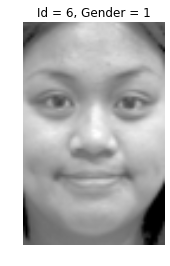

In [11]:
def plot_face(n):
    plt.imshow(dataset.images[n],cmap='gray')
    plt.title('Id = %d, Gender = %d' % (dataset.target[n], dataset.gender[n]))
    plt.axis('off')

interact(plot_face, n=IntSliderWidget(max=dataset.images.shape[0]-1))

## Performing PCA

Center and whiten data.  The first axis (`axis=0`) is the `n_samples` dimension.

In [12]:
X=dataset.data.copy() # So that we won't mess up the data in the dataset\
X_mean=X.mean(axis=0,keepdims=True) # Mean for each dimension across sample
X_std =X.std(axis=0,keepdims=True)
X-=X_mean
X/=X_std
disp(all(abs(X.mean(axis=0))<1e-12))
disp(all(abs(X.std(axis=0) - 1.0)<1e-12))

True
True


Perform SVD to calculate the projection matrix $V$.  By default, `U,s,V=svd(...)` returns full matrices, which will return $n \times n$ matrix `U`, $n$-dimensional vector of singular values `s`, and $d \times d$ matrix `V`.   But here, we don't really need $d \times d$ matrix `V`; with `full_matrices=False`, `svd` only returns $n \times d$ matrix for `V`.

We can also plot how much each eigenvector in `V` contributes to the overall variance, by plotting `s**2`.

(80, 80)
(80,)
(80, 5700)


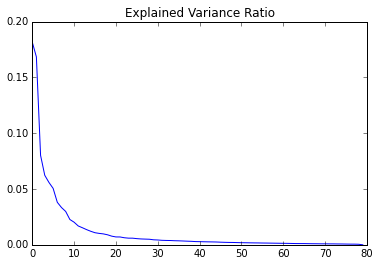

In [13]:
from numpy.linalg import svd
U,s,V=svd(X,compute_uv=True, full_matrices=False)
plt.plot(s**2/(s**2).sum())
plt.title('Explained Variance Ratio')
disp(str(U.shape))
disp(str(s.shape))
disp(str(V.shape))

Plot each eigenface (eigenvectors in `V`). Note that they are rescaled by `X_std`, but the X_mean is not added! (Question: why do you think?) Also note that the plot range is not from 0 to 1.

<function __main__.plot_eigenface>

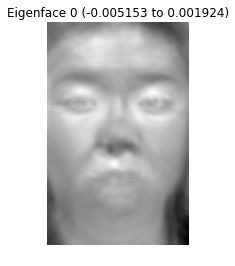

In [14]:
image_shape=dataset.images.shape[1:] # (H x W)
def plot_eigenface(eigenface):
    v=V[eigenface]*X_std
    
    plt.imshow(v.reshape(image_shape), cmap='gray')
    plt.title('Eigenface %d (%f to %f)' % (eigenface, v.min(), v.max()))
    plt.axis('off')
interact(plot_eigenface, eigenface=IntSliderWidget(max=V.shape[0]-1))

Now let's try reconstructing faces with different number of principal components (PCs)!  Now, the transformed `X` is reconstructed by multiplying by the sample standard deviations for each dimension and adding the sample mean. For this reason, even for zero components, you get a face-like image!

The rightmost plot is the "relative" reconstruction error (image minus the reconstruction squared, divided by the data standard deviations).  White is where the error is close to zero, and black is where the relative error is large (1 or more).  As you increase the number of PCs, you should see the error mostly going to zero (white).

<function __main__.reconstruct_with>

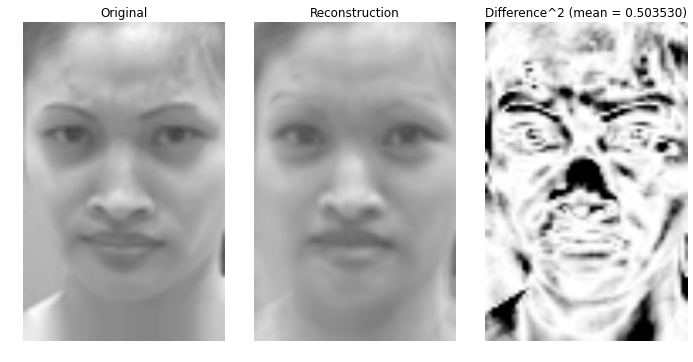

In [15]:
def reconstruct_with(n=0, n_components=10):
    # This is where we perform the projection and un-projection
    Vn=V[:n_components]
    X_hat=dot(dot(X[n], Vn.T), Vn)
    
    # Un-whiten
    I=X[n] * X_std + X_mean
    I_hat = X_hat * X_std + X_mean
    D=multiply(I-I_hat,I-I_hat) / multiply(X_std, X_std)
    
    # And plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
    axs[0].imshow(I.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title('Original')
    
    axs[1].imshow(I_hat.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title('Reconstruction')

    axs[2].imshow(1-D.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[2].axis('off')
    axs[2].set_title('Difference^2 (mean = %f)' % sqrt(D.mean()))
    
    plt.tight_layout()

interact(reconstruct_with,
         n=IntSliderWidget(max=dataset.images.shape[0]-1),
         n_components=IntSliderWidget(value=10, max=V.shape[0]-1))

## Image morphing

In the following, we'll morph two images by taking averages of the two images within the transformed space.

<function __main__.plot_morph>

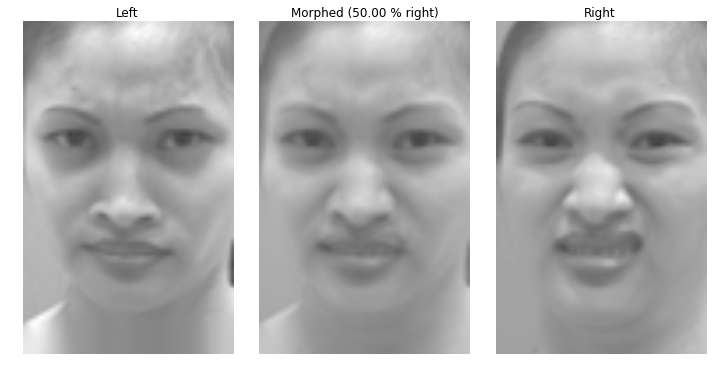

In [16]:
def plot_morph(left=0, right=1, mix=0.5):
    # Projected images
    x_lft=dot(X[left], V.T)
    x_rgt=dot(X[right], V.T)
    
    # Mix
    x_avg = x_lft * (1.0-mix) + x_rgt * (mix)
    
    # Un-project
    X_hat = dot(x_avg[newaxis,:], V)
    I_hat = X_hat * X_std + X_mean
    
    # And plot
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    
    axs[0].imshow(dataset.images[left], cmap='gray', vmin=0, vmax=1)
    axs[0].axis('off')
    axs[0].set_title('Left')
    
    axs[1].imshow(I_hat.reshape(image_shape), cmap='gray', vmin=0, vmax=1)
    axs[1].axis('off')
    axs[1].set_title('Morphed (%.2f %% right)' % (mix * 100))

    axs[2].imshow(dataset.images[right], cmap='gray', vmin=0, vmax=1)
    axs[2].axis('off')
    axs[2].set_title('Right')
    
    plt.tight_layout()

interact(plot_morph,
         left=IntSliderWidget(max=dataset.images.shape[0]-1),
         right=IntSliderWidget(max=dataset.images.shape[0]-1,value=1),
         mix=FloatSliderWidget(value=0.5, min=0, max=1.0))